<a href="https://colab.research.google.com/github/pds2021/a5-franzislytics/blob/assignment_5/Kopie_von_Schrauben__Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 20/21*
# Programming Assignment 5 - Create your own App

In this programming assignment you'll build a model that serves as a foundation for your own app. To this end, you will create your own dataset, build a deep learning model on this data, and deploy it!

In [1]:
!pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 6.0MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 


In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *

__Google Drive integration__

If you want to store and access your downloaded data for this assignment you can use the following code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/My\ Drive/pds_a5
%cd /content/drive/My\ Drive/pds_a5

## Develop an Application Idea

___Free your mind - this part is totally up to you.___

Think of an app that you'd like to build.
*   What useful app have you been missing?
*   Do you have any hobbies an app could be helpful for?
*   Is this a suitable classification or regression task? 
*   How could you get the data?


In [ ]:
# Write down your app idea here

You can get an inspiration from these Apps:

<table>
<tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/5.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/400">Guitar Classifier</a> by Christian Werner</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/6.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/340">Healthy or Not!</a> by Nikhil Utane </td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/7.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/333">Hummingbird Classifier</a> by Nissan Dookeran</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/8.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/409">Edible Mushroom?</a> by Ramon</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/9.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/387">Cousin Recognizer</a> by Charlie Harrington</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/10.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/386">Emotion Classifier</a> by Ethan Sutin and Team 26</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/11.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/350">American Sign Language</a> by Keyur Paralkar</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/12.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/355">Your City from Space</a> by Henri Palacci</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/13.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/367">Univariate TS as images using Gramian Angular Field</a> by Ignacio Oguiza</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/14.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/348">Face Expression Recognition</a> by Pierre Guillou</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/15.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/352">Tumor-normal sequencing</a> by Alena Harley</td><td>  </td>
</tr><table>

## Creating your own Dataset

Now you need to construct a dataset that allows you to train a model for your app. You learned about how to create a dataset in Lecture 7.

Here, you can follow the steps from the lecture or look into the following ressources:

*   A [tool](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md) for excluding irrelevant images from Google Image Search results beforehand by @melonkernel
*   See this [post](https://www.christianwerner.net/tech/Build-your-image-dataset-faster/) about an alternative image downloader/cleaner by @cwerner
*   Of course, you can use your own data/images :) 

### 1. Dowload the data 
- You may use the helper functions from the lecture to get the image URLs
- Create a new folder at your defined `path`
- Use `download_image` to download the images into the corresponding (sub-)directories

In [3]:
import requests
import re
import json
from fastcore.foundation import L

def search_images_ddg(key,max_n=150):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api and 
    https://github.com/fastai/fastbook/blob/master/utils.py)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [4]:
ims = search_images_ddg('Schraube')
len(ims)

145

In [5]:
pd.DataFrame({'urls':ims})

,urls
0,https://media.boellhoff.com/files/jpg1/amtec-schraube-fuer-thermoplastische-kunststoffe.jpg
1,https://www.kabelschuhe-shop.de/media/image/product/7625/lg/sw-stahl-03011l-schraube-mit-aludichtung-m15-x-15.jpg
2,https://allis-wunderland.de/media/image/product/3133/lg/250-st-m6-x-25-mm-88-torx-din-7991-senk-schraube-verzinkt-lageraufloesung-s084_1~2.jpg
3,https://www.rolladen-shop.de/media/image/49/08/5f/10-Staeueck-selbstschneidende-Schraube-M4x12-mit-Bohrspi.jpg
4,http://shop.sommercable.com/out/pictures/master/product/1/a_3191_otsi1.jpg
...,...
140,https://www.bikehardest.net/shop/bilder/produkte/gross/Titan-Schraube-M6-x-10-30-Sechskant-mit-Bund-DIN-6921-Grade-5-Gruen.jpg
141,http://www.savetix.de/gif/einbauanleitung/savetix-unverlierbare-schraube-anleitung-falscher-einbau.jpg
142,https://www.racing-planet.de/images/gross/138/piAP9100433_schraube_oem_m6x50_piaggio_aprilia.jpg
143,https://i.ytimg.com/vi/pojWKohkAEA/maxresdefault.jpg


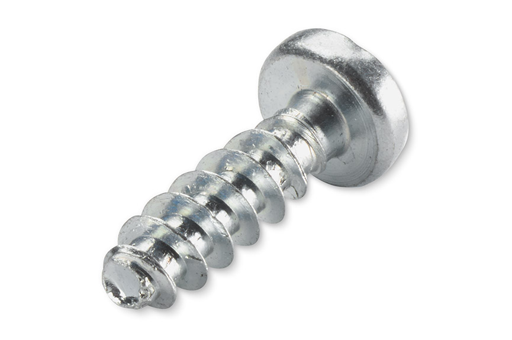

In [6]:
dest = 's1.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(512,512)

### 2. Verify Images
- First, create a list of all your images
- Use `verify_images` and `unlink` to remove broken images

In [7]:
schrauben_types = 'Längsschlitz', 'Kreuzschlitz', 'Sechskant', 'Torx'
path = Path('Schrauben')

In [8]:
if not path.exists(): path.mkdir()
for o in schrauben_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} Schraube')
    download_images(dest, urls=results)

In [9]:
fns = get_image_files(path)
fns

(#517) [Path('Schrauben/Torx/00000008.jpg'),Path('Schrauben/Torx/00000079.jpg'),Path('Schrauben/Torx/00000131.jpg'),Path('Schrauben/Torx/00000129.jpg'),Path('Schrauben/Torx/00000071.jpg'),Path('Schrauben/Torx/00000069.jpg'),Path('Schrauben/Torx/00000114.jpg'),Path('Schrauben/Torx/00000058.jpg'),Path('Schrauben/Torx/00000019.jpg'),Path('Schrauben/Torx/00000063.jpg')...]

In [10]:
failed = verify_images(fns)
failed 

(#3) [Path('Schrauben/Kreuzschlitz/00000004.jpg'),Path('Schrauben/Sechskant/00000081.jpg'),Path('Schrauben/Sechskant/00000108.jpg')]

In [11]:
failed.map(Path.unlink)

(#3) [None,None,None]

### 3. Create the DataBlock
For this, you need to think of:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Use `RandomResizedCrop` for `item_tfms`with an image size of 224 px, and the appropriate `aug_transforms` as `batch_tfms`.

In [12]:
schraub = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms())

### 4. Create the DataLoaders

In [13]:
dls = schraub.dataloaders(path)

### 5. Take a look at some of your pictures. 
Does everything look as expected?

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


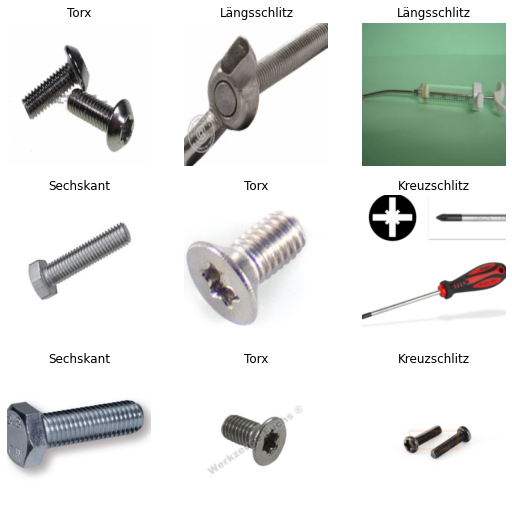

In [14]:
dls.valid.show_batch(max_n=9, nrows=3)

## Modeling

### 6. Create a learner

Create an appropriate learner for your data
- Choose an appropriate model [architecture](https://fastai1.fast.ai/vision.models.html)
- Choose appropriate [metrics](https://docs.fast.ai/metrics.html) for your task

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
#learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
#interp.plot_top_losses(5, nrows=1)

### 7. Fit the model

Use your knowdledge on model training to fit your model!

In [16]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.328458,1.904309,0.568627,00:06


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.802255,1.513618,0.490196,00:06
1,1.584290,1.423563,0.431373,00:06
2,1.467927,1.246427,0.372549,00:06
3,1.329078,1.201404,0.392157,00:06


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(3, lr_max=0.001)

In [ ]:
#learn.save('stage-1')

### 8. Evaluate the model

You' ve already seen many ways to evaluate a model. Evaluate your model in a qualitative and quantitative manner.

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


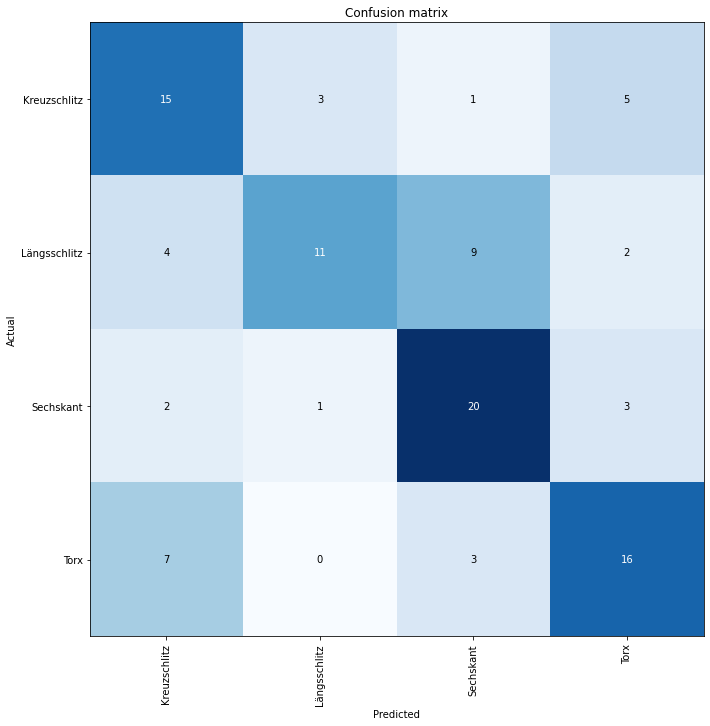

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

#rows represent all types of screws in dataset
#columns represent images which the model predicted as certain types of screws

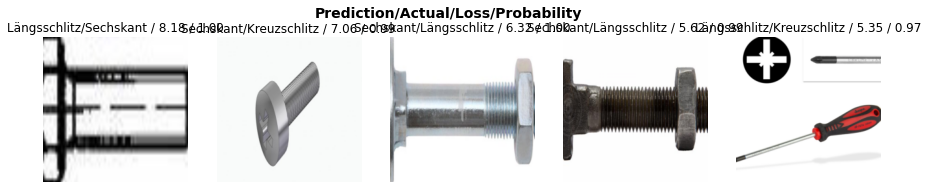

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
interp.most_confused(min_val=2)

[('Längsschlitz', 'Sechskant', 9),
 ('Torx', 'Kreuzschlitz', 7),
 ('Kreuzschlitz', 'Torx', 5),
 ('Längsschlitz', 'Kreuzschlitz', 4),
 ('Kreuzschlitz', 'Längsschlitz', 3),
 ('Sechskant', 'Torx', 3),
 ('Torx', 'Sechskant', 3),
 ('Längsschlitz', 'Torx', 2),
 ('Sechskant', 'Kreuzschlitz', 2)]

### 9. Clean your data

Based on the evaluation, you may want to clean your data using the `ImageClassifierCleaner`.
- Remeber to delete the selected data after using the cleaner:
    ```python
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    ```
    
    
- Once we've cleaned up our data, we can retrain our model. 



In [20]:
cleaner = ImageClassifierCleaner(learn)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
cleaner

In [22]:
  for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [23]:
#move images for which we've selected a different category

for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [24]:
#retrain

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.304277,2.022939,0.549020,00:06


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.635923,1.555982,0.490196,00:06
1,1.583483,1.170128,0.431373,00:06
2,1.453830,1.156203,0.401961,00:06
3,1.331223,1.151634,0.372549,00:06


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Turning Your Model into an Online Application

Now, take your app into production. You can follow the steps from the lecure:

- Export your model via `learn.export`
- Upload your model to [Github Releases](https://docs.github.com/en/free-pro-team@latest/github/administering-a-repository/about-releases) to make it publicly available at your repository.
- Create and upload a new notebook that only contains the necassary code and IPython widgets for your App. 
    - Remeber to download the exported model from *Github Releases*
    - Include a brief description of your app and the functionalities
- Publish your web app on [Binder](https://mybinder.org/) using Voilà

You can use the [example](https://github.com/pds2021/course/blob/main/nbs/07_Bear_App.ipynb) from the lecture as an orientation.

If you're familiar with the world of web application development, you're free to use these skills and all your tools and ressources!

In [25]:
learn.export()

## Finally, Provide a Link to Your App

In [ ]:
# Provide the link to your web app